# Setting up Gpu

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


# Imports

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", message="No artists with labels found to put in legend.") 
warnings.filterwarnings("ignore", category=FutureWarning)
import cv2
import os
import pathlib
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_gan as tfgan
from tensorflow.keras.applications import VGG16
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.linalg import sqrtm
SEED = 36
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2024-11-28 06:31:43.882598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.__version__

'2.13.0'

# Loading Data

In [4]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [5]:
readDatasetObject = ReadDataset('chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [6]:
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


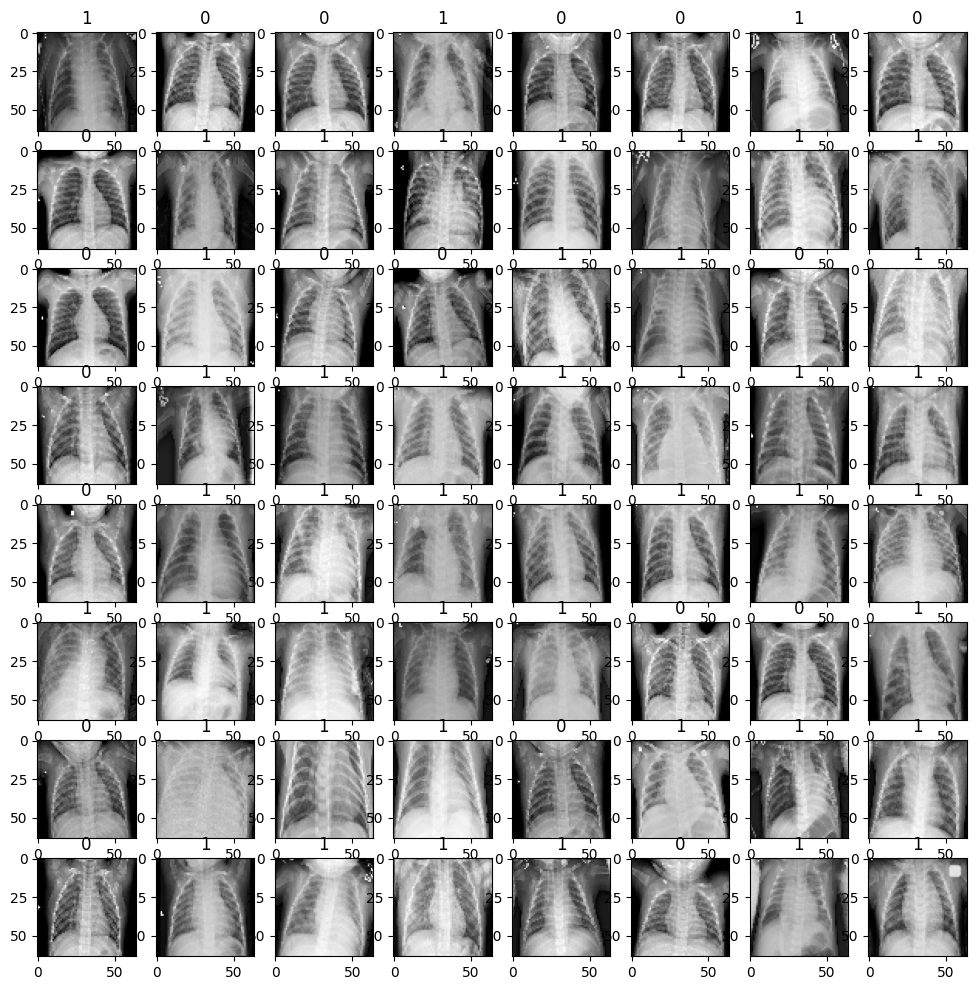

In [7]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]], cmap='gray')
    plt.title(labels[indexs[i]])
plt.legend()

# Defining the GAN module

In [8]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size, label_smoothing=0.9):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
        self.label_smoothing = label_smoothing

    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap='gray')
            plt.title(ys[i])
        plt.show()


    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(2048)(x)
        x = layers.Dense(8*8*filters[0], kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = layers.LayerNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding, strides=strides)(x)
        x = Conv2DTranspose(1, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels], outputs=x, name='generator')

    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding, strides=strides,
                      kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1)(x)
        labelsOutput = Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs, outputs=[outputs, labelsOutput], name='discriminator')

    def build(self):
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2,))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss=['mse', 'binary_crossentropy'],
                 optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta, weight_decay=self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs=[generatorInput, labelsInput], outputs=D(G([generatorInput, labelsInput])))
        GAN.compile(loss=['mse', 'binary_crossentropy'],
                   optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta*0.5, weight_decay=self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN

    def save_model_weights(self, G, D, GAN, epoch):
        G.save_weights(f'generator_weights_epoch_{epoch}.h5')
        D.save_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.save_weights(f'gan_weights_epoch_{epoch}.h5')

    def load_model_weights(self, G, D, GAN, epoch):
        G.load_weights(f'generator_weights_epoch_{epoch}.h5')
        D.load_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.load_weights(f'gan_weights_epoch_{epoch}.h5')

    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size=(self.batch_size,))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape=(self.batch_size,))*self.label_smoothing
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)), num_classes=2)
            fakeImages = G.predict([noize, fakeLabels], verbose=0)
            fakeTag = tf.zeros(shape=(self.batch_size,))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 10000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag, dlossLabels, glossTag, glossLabels))
                self.samples(G, noize, fakeLabels)
                # Save model weights
                self.save_model_weights(G, D, GAN, epoch)

# Instantiating the model

In [9]:
acgan = Acgan(eta = 0.0002, batch_size = 32, epochs = 62000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 1), kernel_size = 5)

In [10]:
acgan.data(images, labels)

In [11]:
G, D, GAN = acgan.build()

2024-11-28 06:32:18.234909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           832       ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu_4[0][0]']       
                                                                                      

# Training

In [12]:
last_epoch = 60000
acgan.load_model_weights(G, D, GAN, last_epoch)

In [13]:
#acgan.trainAlgorithm(G, D, GAN)

In [14]:
#G.save('/tf/Model/generator.h5')

In [15]:
#G = tf.keras.models.load_model('/tf/Model/generator.h5')

# Evaluation

In [16]:
datasetGenerationSize = 5216
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [17]:
noize.shape, newlabels.shape

(TensorShape([5216, 100]), (5216, 2))

In [18]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([2533, 2683]))

In [19]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

2024-11-28 06:32:20.395014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


163/163 [==============================] - 2s 9ms/step


(5216, 64, 64, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


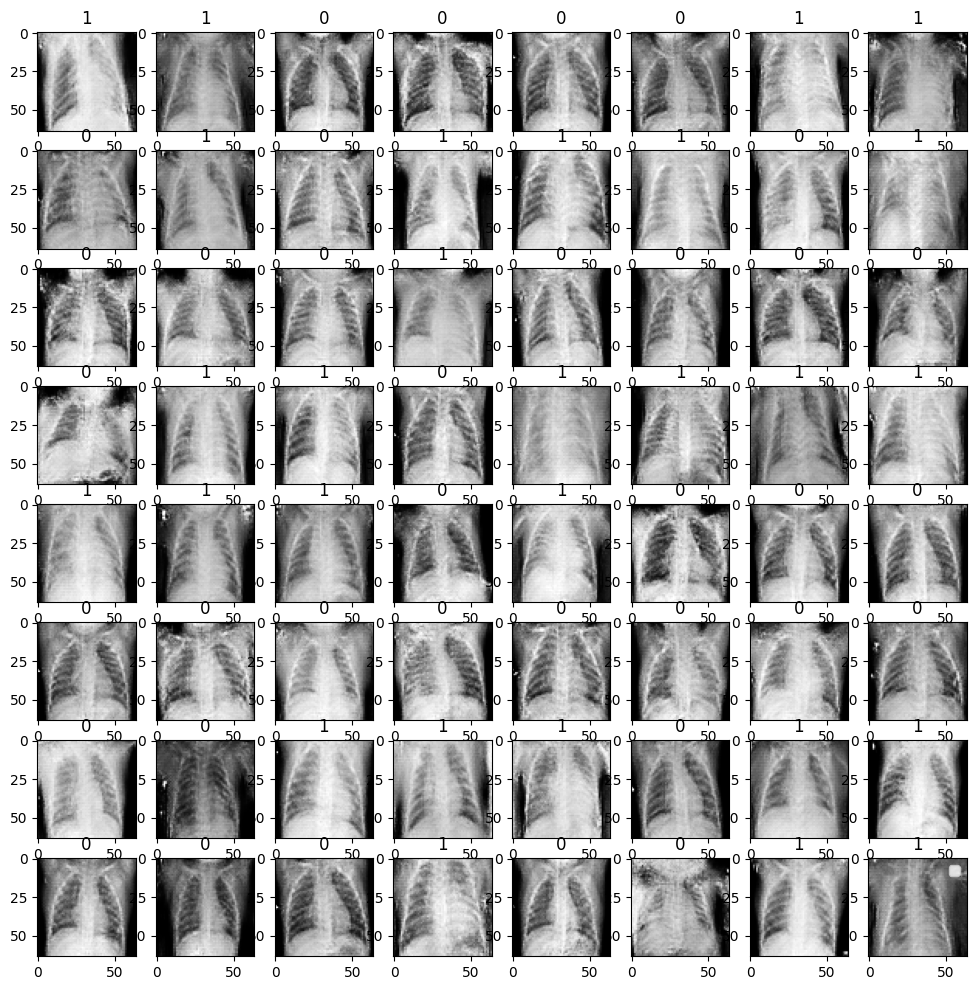

In [20]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i],cmap='gray')
    plt.title(t[i])
plt.legend()

In [21]:
# Using VGG16 with pre-trained weights for fine-tuning
basemodel = tf.keras.applications.VGG16(weights=None, input_shape=(64, 64, 1),
                                        pooling='max', include_top=False)
# Model architecture
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Assuming binary classification
m = tf.keras.models.Model(inputs=basemodel.input, outputs=x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [22]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60


2024-11-28 06:32:33.954532: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f22f87926a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-28 06:32:33.954598: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-11-28 06:32:33.964489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 06:32:34.129153: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 [==============================] - 11s 57ms/step - loss: 0.5217 - val_loss: 0.6910
Epoch 2/60
66/66 [==============================] - 2s 36ms/step - loss: 0.2271 - val_loss: 0.6842
Epoch 3/60
66/66 [==============================] - 2s 36ms/step - loss: 0.1693 - val_loss: 0.6713
Epoch 4/60
66/66 [==============================] - 2s 36ms/step - loss: 0.1443 - val_loss: 0.6439
Epoch 5/60
66/66 [==============================] - 2s 36ms/step - loss: 0.1212 - val_loss: 0.5876
Epoch 6/60
66/66 [==============================] - 2s 36ms/step - loss: 0.1018 - val_loss: 0.5227
Epoch 7/60
66/66 [==============================] - 2s 36ms/step - loss: 0.0969 - val_loss: 0.4447
Epoch 8/60
66/66 [==============================] - 2s 36ms/step - loss: 0.0908 - val_loss: 0.3422
Epoch 9/60
66/66 [==============================] - 2s 36ms/step - loss: 0.0828 - val_loss: 0.2242
Epoch 10/60
66/66 [==============================] - 2s 36ms/step - loss: 0.0754 - val_loss: 0.1186
Epoch 11/60
66/66 [

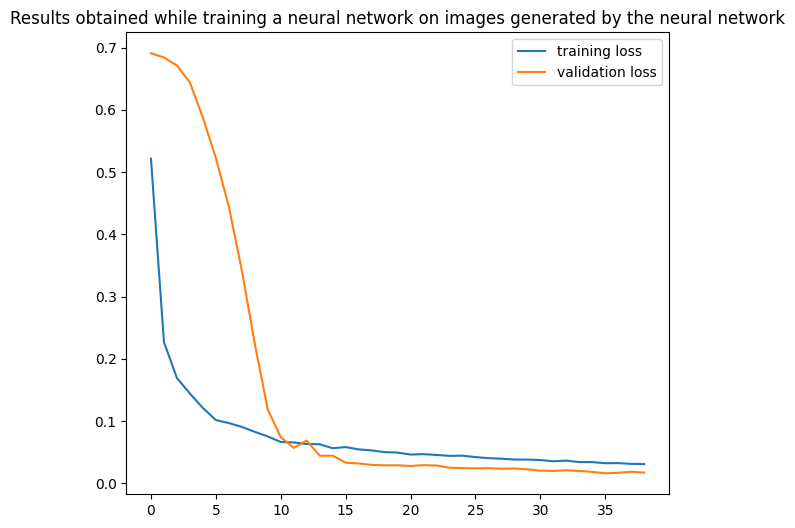

In [23]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [24]:
readDatasetObject = ReadDataset('/tf/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images_test, labels_test = readDatasetObject.readImages()

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
def calculate_metrics(model, images, labels):
    loss = model.evaluate(images, labels, verbose=0)  
    y_pred = tf.squeeze(model.predict(images))
    y_pred = y_pred >= 0.5
    y_pred = np.array(y_pred, dtype='int32')
    labels = np.array(labels, dtype='int32')
    acc = accuracy_score(y_pred, labels) * 100
    f1 = f1_score(y_pred, labels) * 100
    recall = recall_score(y_pred, labels) * 100
    precision = precision_score(y_pred, labels) * 100
    cm = confusion_matrix(y_pred, labels)
    cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
    sns.heatmap(cmObject, annot = True, cmap="Blues")
    return {
        'accuracy': acc,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'confusion_matrix': cm
    }


20/20 [==============================] - 0s 6ms/step
1:1 Ratio -> Accuracy: 86.22%, F1 Score: 88.83%, Recall: 90.00%, Precision: 87.69%


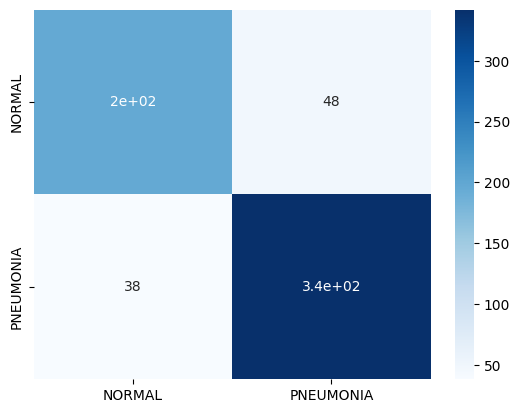

In [28]:
metrics = calculate_metrics(m, images_test, labels_test)
print(f"1:1 Ratio -> Accuracy: {metrics['accuracy']:.2f}%, F1 Score: {metrics['f1_score']:.2f}%, "
      f"Recall: {metrics['recall']:.2f}%, Precision: {metrics['precision']:.2f}%")

In [29]:
print(metrics['confusion_matrix'])

[[196  48]
 [ 38 342]]
